In [1]:
import tqdm
import numpy as np
import scipy
import torch
import torch.nn as nn
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split

In [101]:
plt.rcParams['figure.dpi'] = 300

In [69]:
variant = 'moons'
# variant = 'blobs'

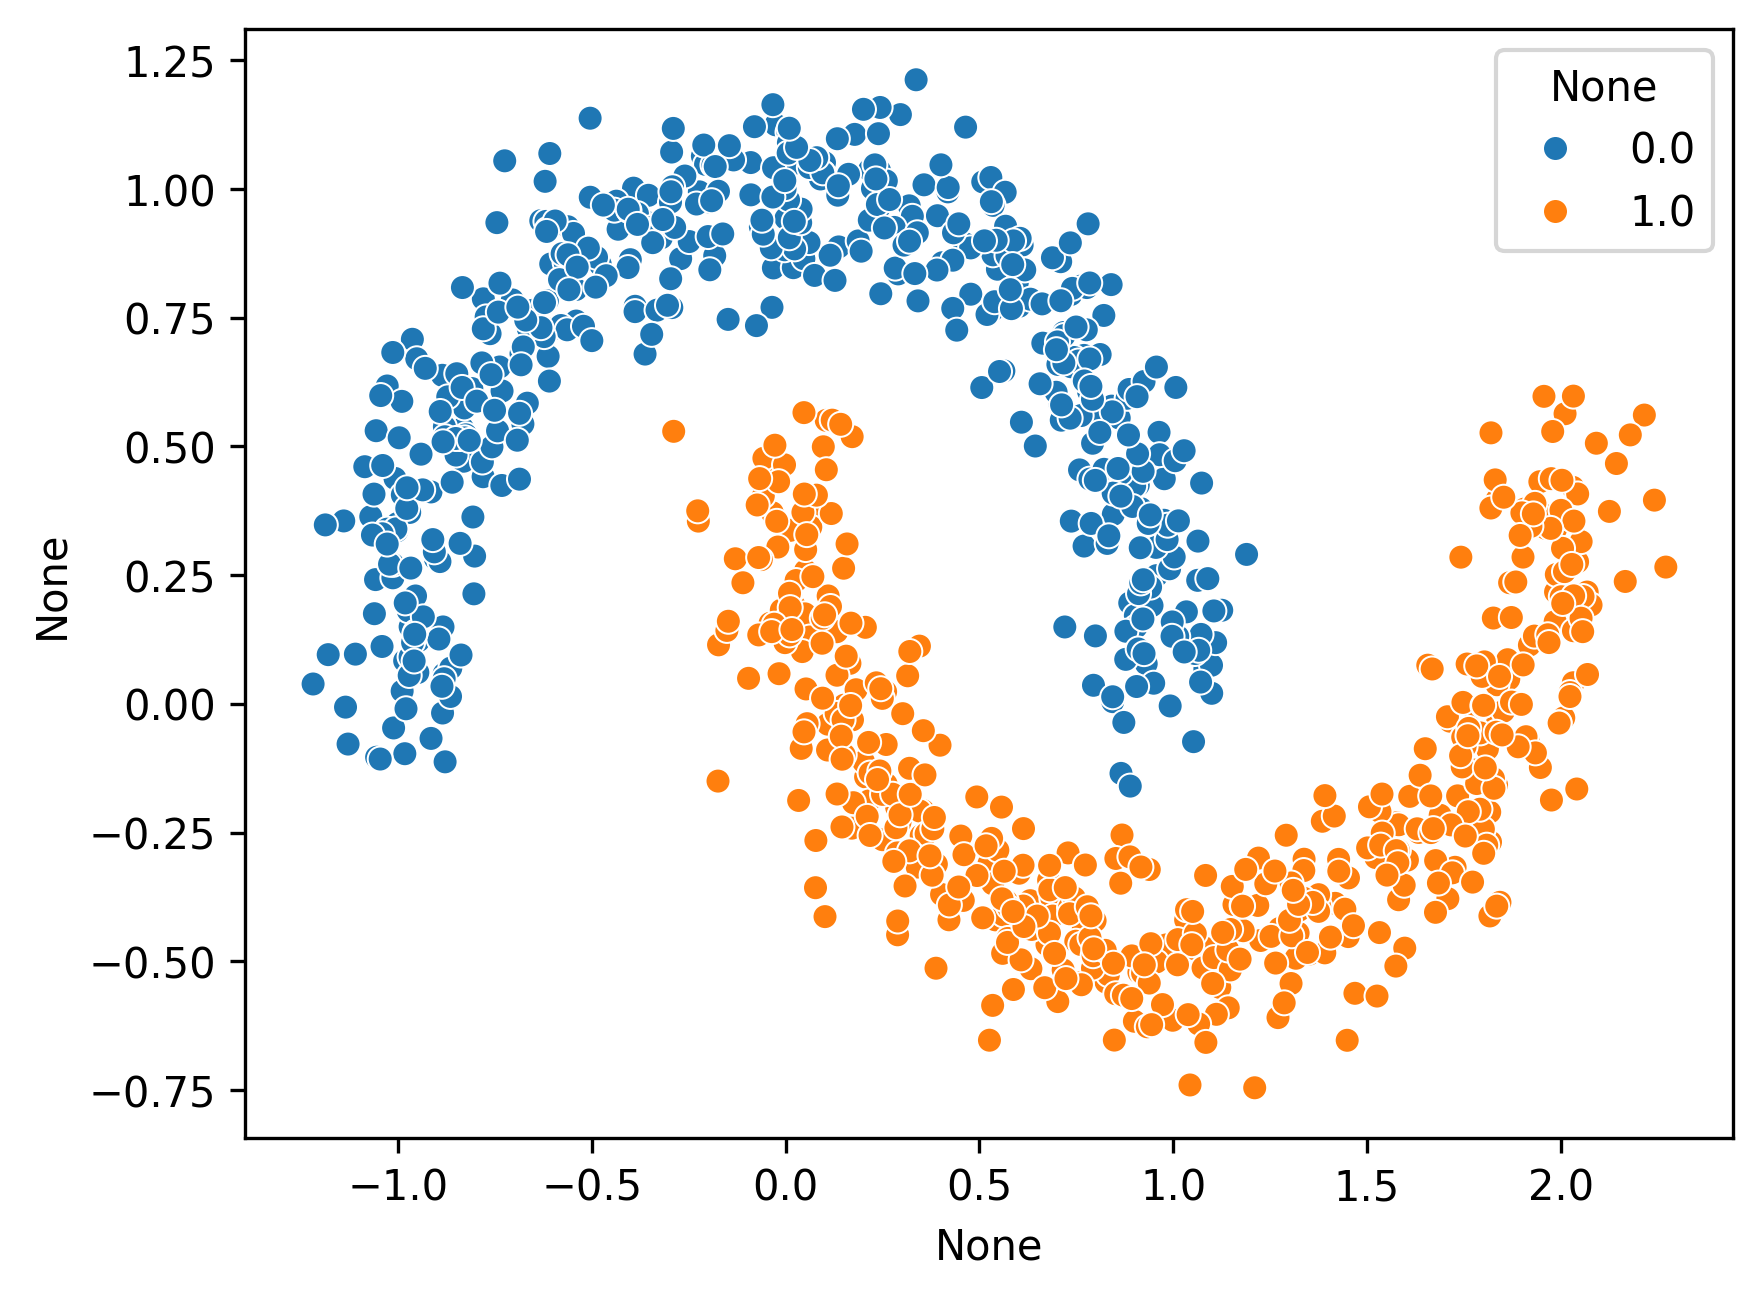

In [70]:
if variant == 'moons':
    X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape(-1, 1)
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

    sns.scatterplot(x=X.T[0], y=X.T[1], hue=y.reshape(-1))

else:
    X, y = make_blobs(n_samples=1000, centers=[[-2, -2], [2, 2]], n_features=2, random_state=42)
    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape(-1, 1)
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

    sns.scatterplot(x=X.T[0], y=X.T[1], hue=y.reshape(-1))

In [71]:
if variant == 'moons':
    class Model(nn.Module):
        def __init__(self, hidden_size=1028):
            super().__init__()
            self.layer_1 = nn.Linear(2, hidden_size)
            self.layer_2 = nn.Linear(hidden_size, 1)
            self.act = nn.ReLU()
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.sigmoid(self.layer_1(x))
            x = self.sigmoid(self.layer_2(x))
            return x

else:
    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.layer_1 = nn.Linear(2, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.sigmoid(self.layer_1(x))
            return x

In [72]:
model = Model()
epochs = 100

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for n in tqdm.tqdm(range(epochs)):
    for i in range(len(train_x)):
        y_hat = model(train_x[i].reshape(1, -1))
        loss = loss_fn(y_hat, train_y[i].reshape(-1, 1))
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

model.eval()

with torch.no_grad():
    y_hat = model(test_x)

100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


In [99]:
viz_samples = 500000
viz_dotsize = 10

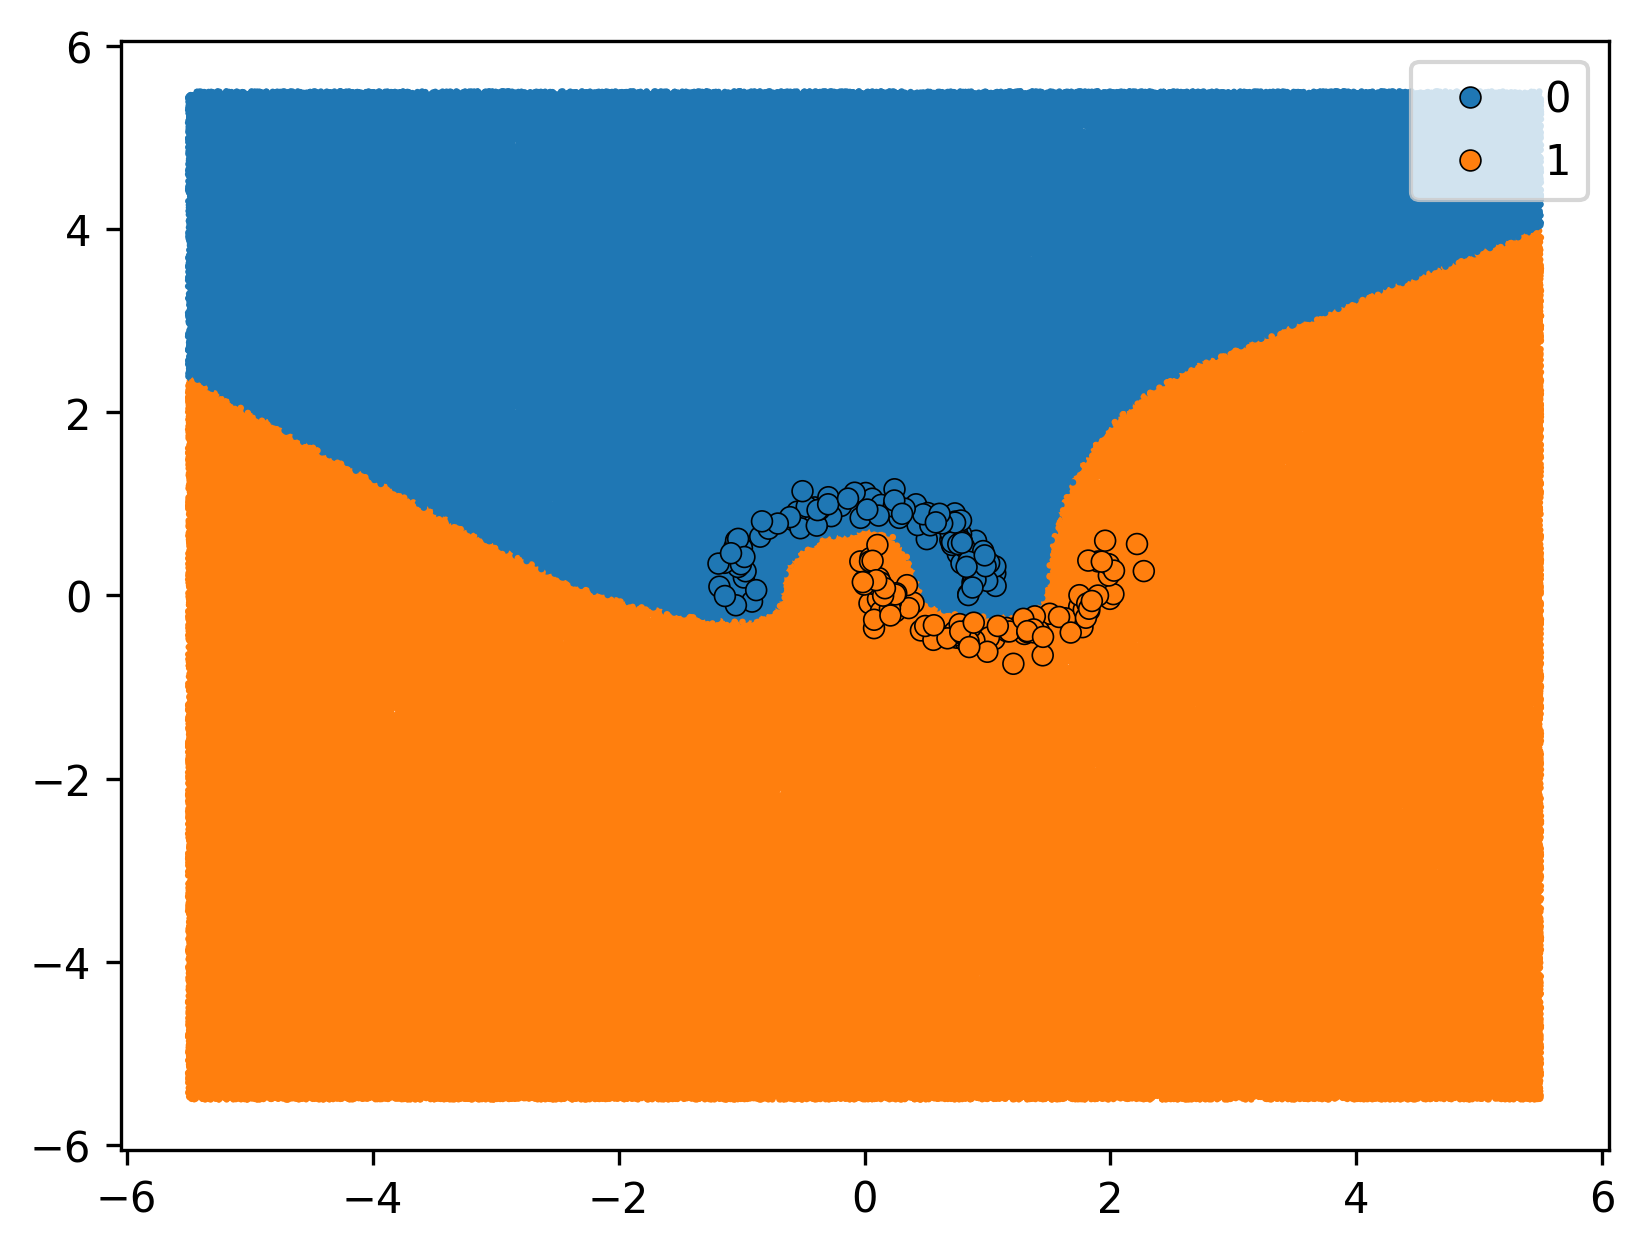

In [103]:
viz_x = np.linspace((-5.5, -5.5), (5.5, 5.5), viz_samples)
viz_x = torch.tensor(np.random.default_rng().permuted(viz_x.T, axis=1).T, dtype=torch.float32)

with torch.no_grad():
    viz_y_hat = model(viz_x)

sns.scatterplot(x=viz_x.T[0], y=viz_x.T[1], hue=viz_y_hat.T[0].round(), marker='.', edgecolor=None, legend=None, linewidth=0, s=viz_dotsize)
ax = sns.scatterplot(x=test_x.T[0], y=test_x.T[1], hue=y_hat.T[0].round().int(), edgecolor='black', s=25)
ax.get_legend().set_title(None)
ax.set_ylabel(None)
ax.set_xlabel(None)

plt.savefig('figures/decision_surface.png', format='png', transparent=True)

In [104]:
if variant == 'moons':
    dim = 5.5
else:
    dim = 25.5

viz_x_l = np.linspace((-dim, -dim), (dim, dim), viz_samples)
viz_x_l = torch.tensor(np.random.default_rng().permuted(viz_x_l.T, axis=1).T, dtype=torch.float32)

viz_loss_0 = []
viz_loss_1 = []
viz_loss_max = []
viz_loss_avg = []

for x in tqdm.tqdm(viz_x_l):
    viz_y_hat = model(x.reshape(1, -1))
    loss_0 = loss_fn(viz_y_hat, torch.tensor([[0.]])).item()
    loss_1 = loss_fn(viz_y_hat, torch.tensor([[1.]])).item()

    viz_loss_0.append(loss_0)
    viz_loss_1.append(loss_1)
    viz_loss_max.append(max(loss_0, loss_1))
    viz_loss_avg.append(np.mean((loss_0, loss_1)))

viz_loss_0 = torch.tensor(viz_loss_0)
viz_loss_1 = torch.tensor(viz_loss_1)
viz_loss_max = torch.tensor(viz_loss_max)
viz_loss_avg = torch.tensor(viz_loss_avg)

100%|██████████| 500000/500000 [00:35<00:00, 14169.23it/s]


Text(0.5, 1.0, 'Maximum Class Loss')

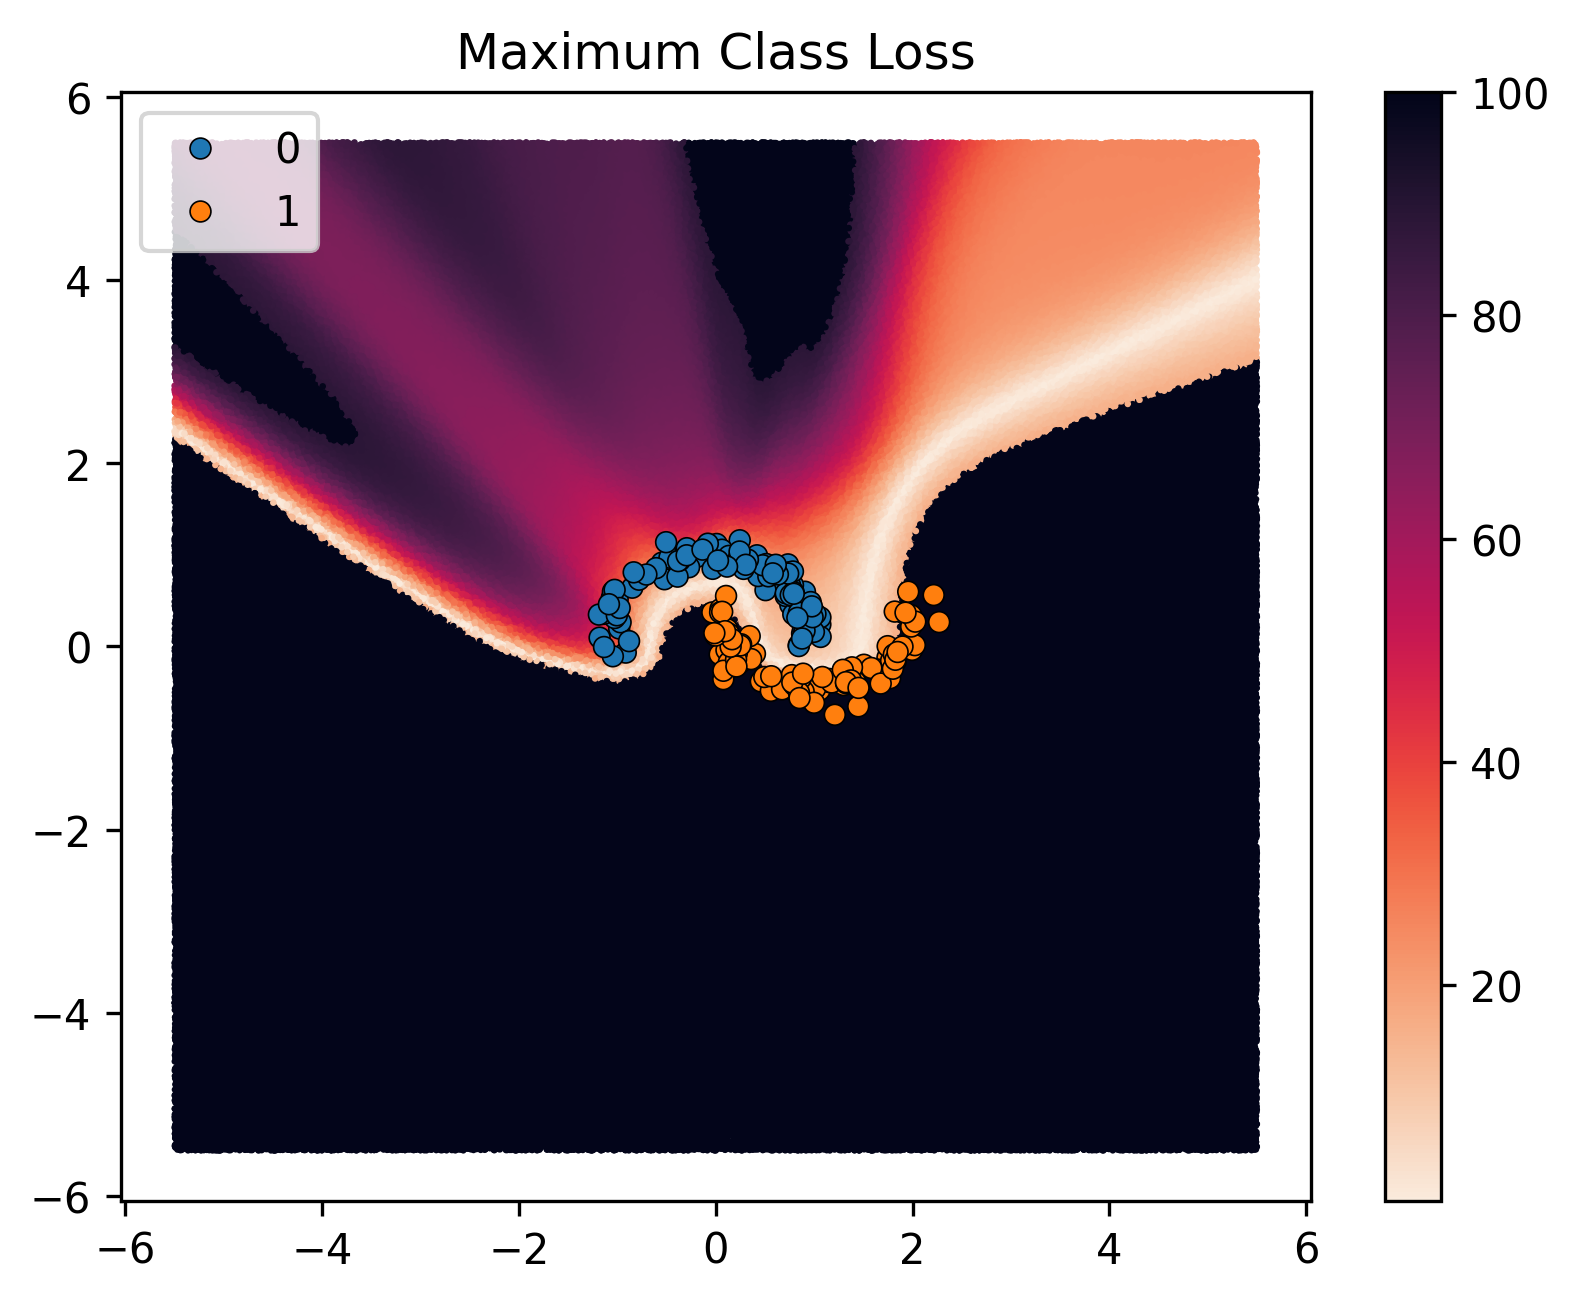

In [109]:
sns.scatterplot(x=viz_x_l.T[0], y=viz_x_l.T[1], hue=viz_loss_max, marker='.', edgecolor=None, legend=None, palette='rocket_r', linewidth=0, s=viz_dotsize)
ax = sns.scatterplot(x=test_x.T[0], y=test_x.T[1], hue=y_hat.T[0].round().int(), edgecolor='black', s=25)
ax.get_legend().set_title(None)
ax.set_ylabel(None)
ax.set_xlabel(None)

norm = plt.Normalize(viz_loss_max.min(), viz_loss_max.max())
sm = plt.cm.ScalarMappable(cmap='rocket_r', norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, ax=ax)

plt.savefig('figures/maximum_class_loss.png', format='png', transparent=True)

plt.title('Maximum Class Loss')

Text(0.5, 1.0, 'Average Class Loss')

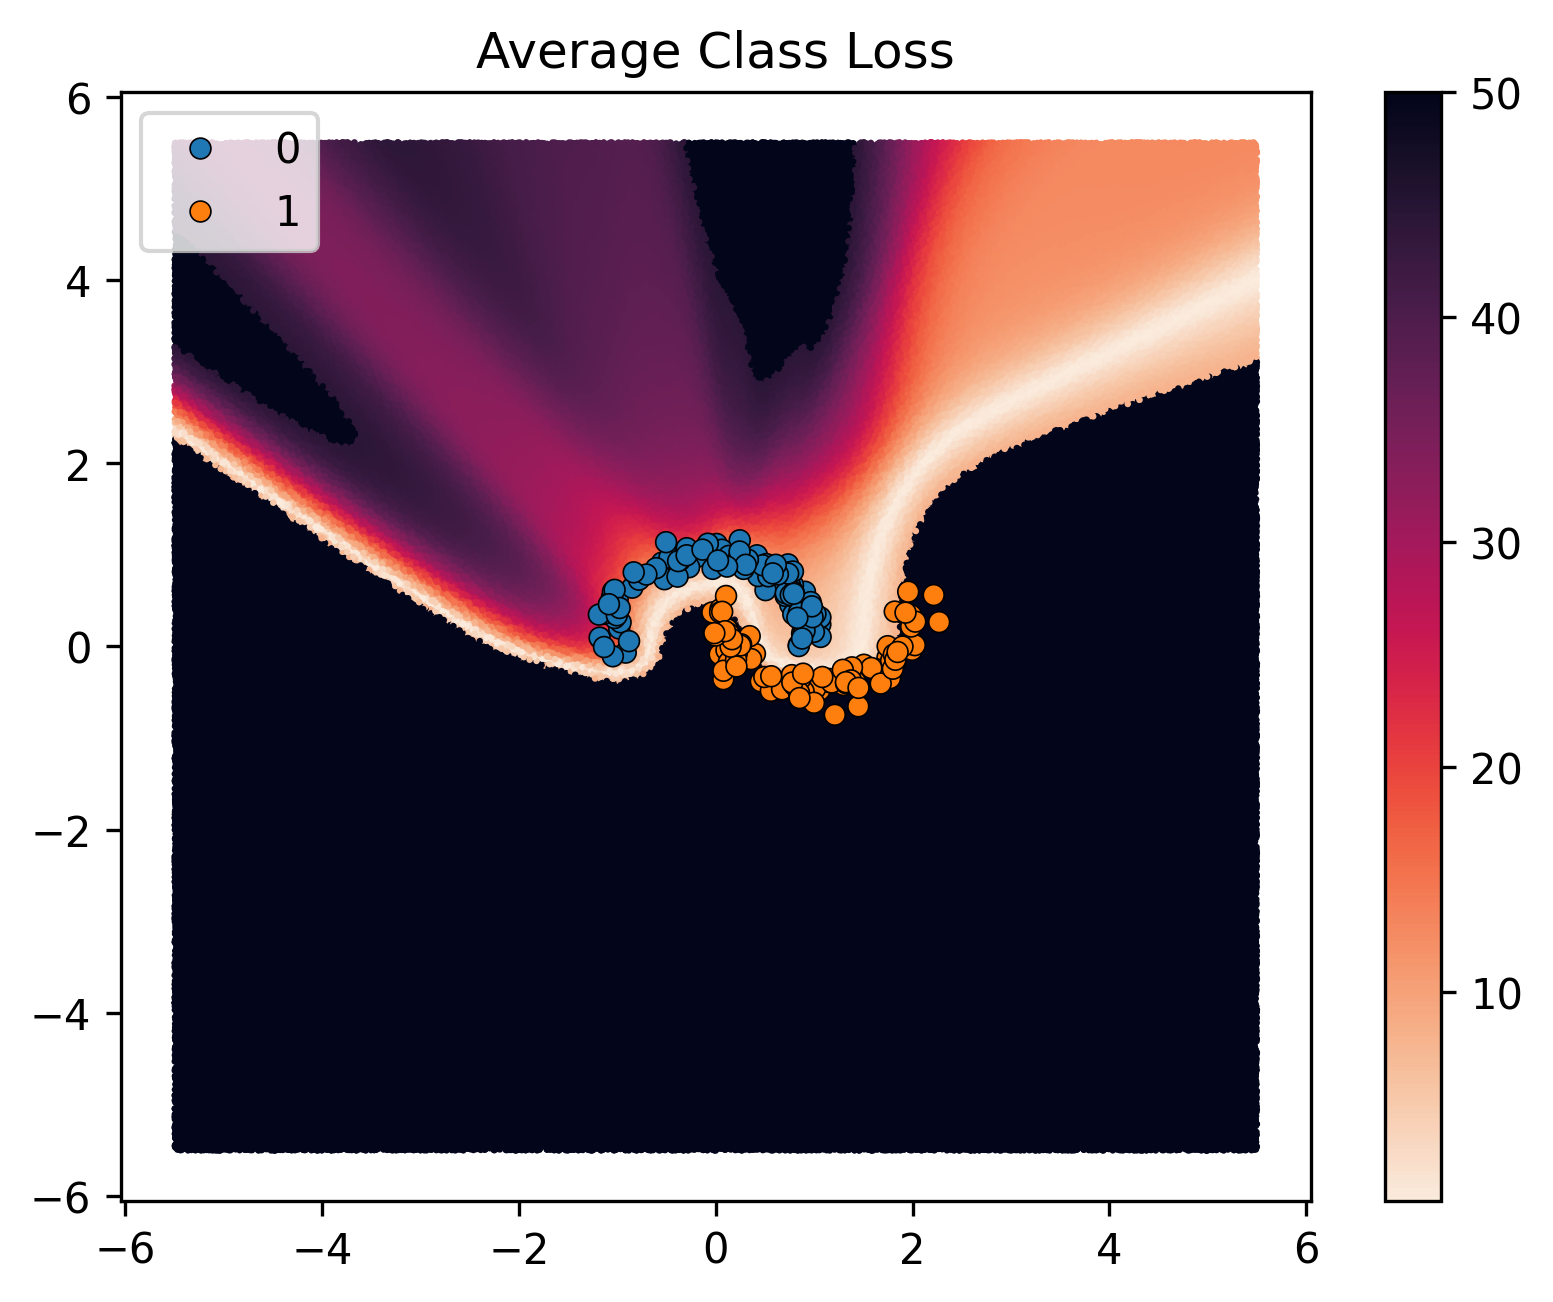

In [110]:
sns.scatterplot(x=viz_x_l.T[0], y=viz_x_l.T[1], hue=viz_loss_avg, marker='.', edgecolor=None, legend=None, palette='rocket_r', linewidth=0, s=viz_dotsize)
ax = sns.scatterplot(x=test_x.T[0], y=test_x.T[1], hue=y_hat.T[0].round().int(), edgecolor='black', s=25)
ax.get_legend().set_title(None)
ax.set_ylabel(None)
ax.set_xlabel(None)

norm = plt.Normalize(viz_loss_avg.min(), viz_loss_avg.max())
sm = plt.cm.ScalarMappable(cmap='rocket_r', norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, ax=ax)

plt.savefig('figures/average_class_loss.png', format='png', transparent=True)

plt.title('Average Class Loss')

Text(0.5, 1.0, 'Class 0 Loss')

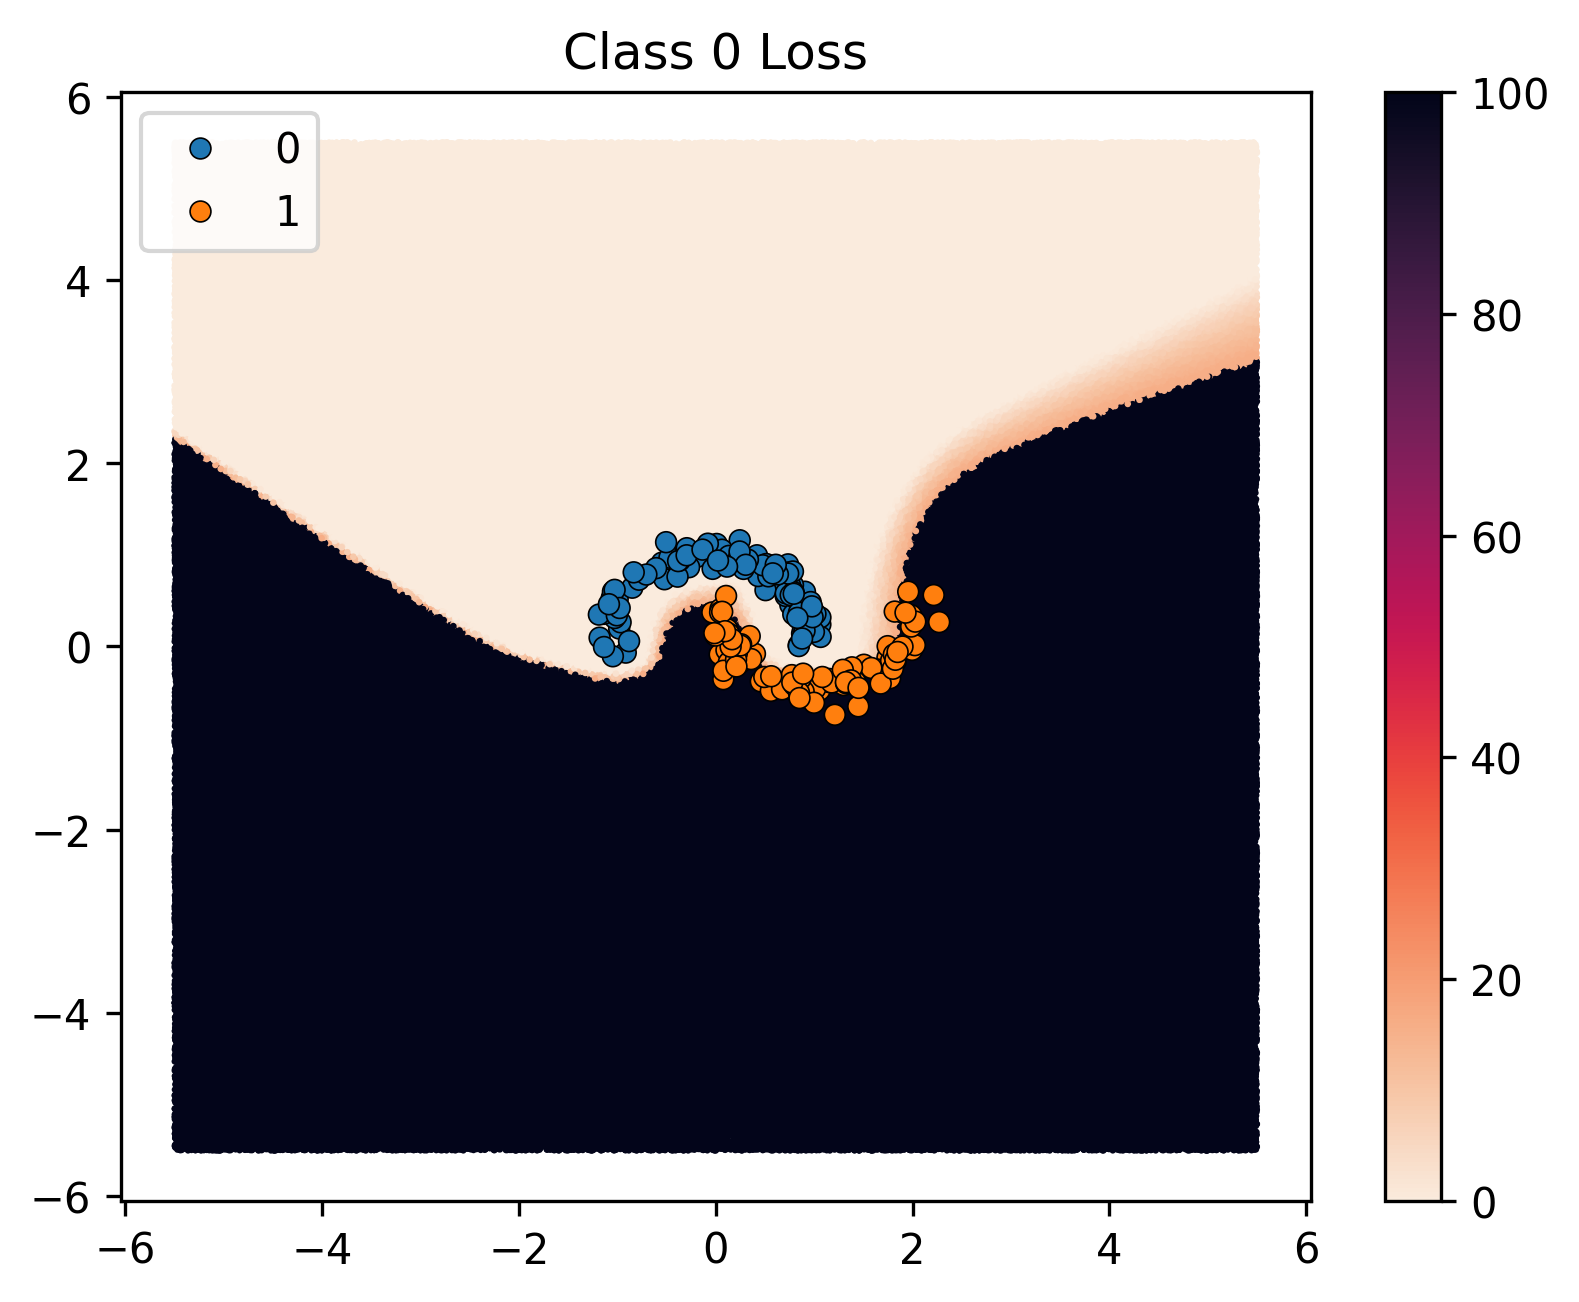

In [111]:
sns.scatterplot(x=viz_x_l.T[0], y=viz_x_l.T[1], hue=viz_loss_0, marker='.', edgecolor=None, legend=None, palette='rocket_r', linewidth=0, s=viz_dotsize)
ax = sns.scatterplot(x=test_x.T[0], y=test_x.T[1], hue=y_hat.T[0].round().int(), edgecolor='black', s=25)
ax.get_legend().set_title(None)
ax.set_ylabel(None)
ax.set_xlabel(None)

norm = plt.Normalize(viz_loss_0.min(), viz_loss_0.max())
sm = plt.cm.ScalarMappable(cmap='rocket_r', norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, ax=ax)

plt.savefig('figures/class_0_loss.png', format='png', transparent=True)

plt.title('Class 0 Loss')

Text(0.5, 1.0, 'Class 1 Loss')

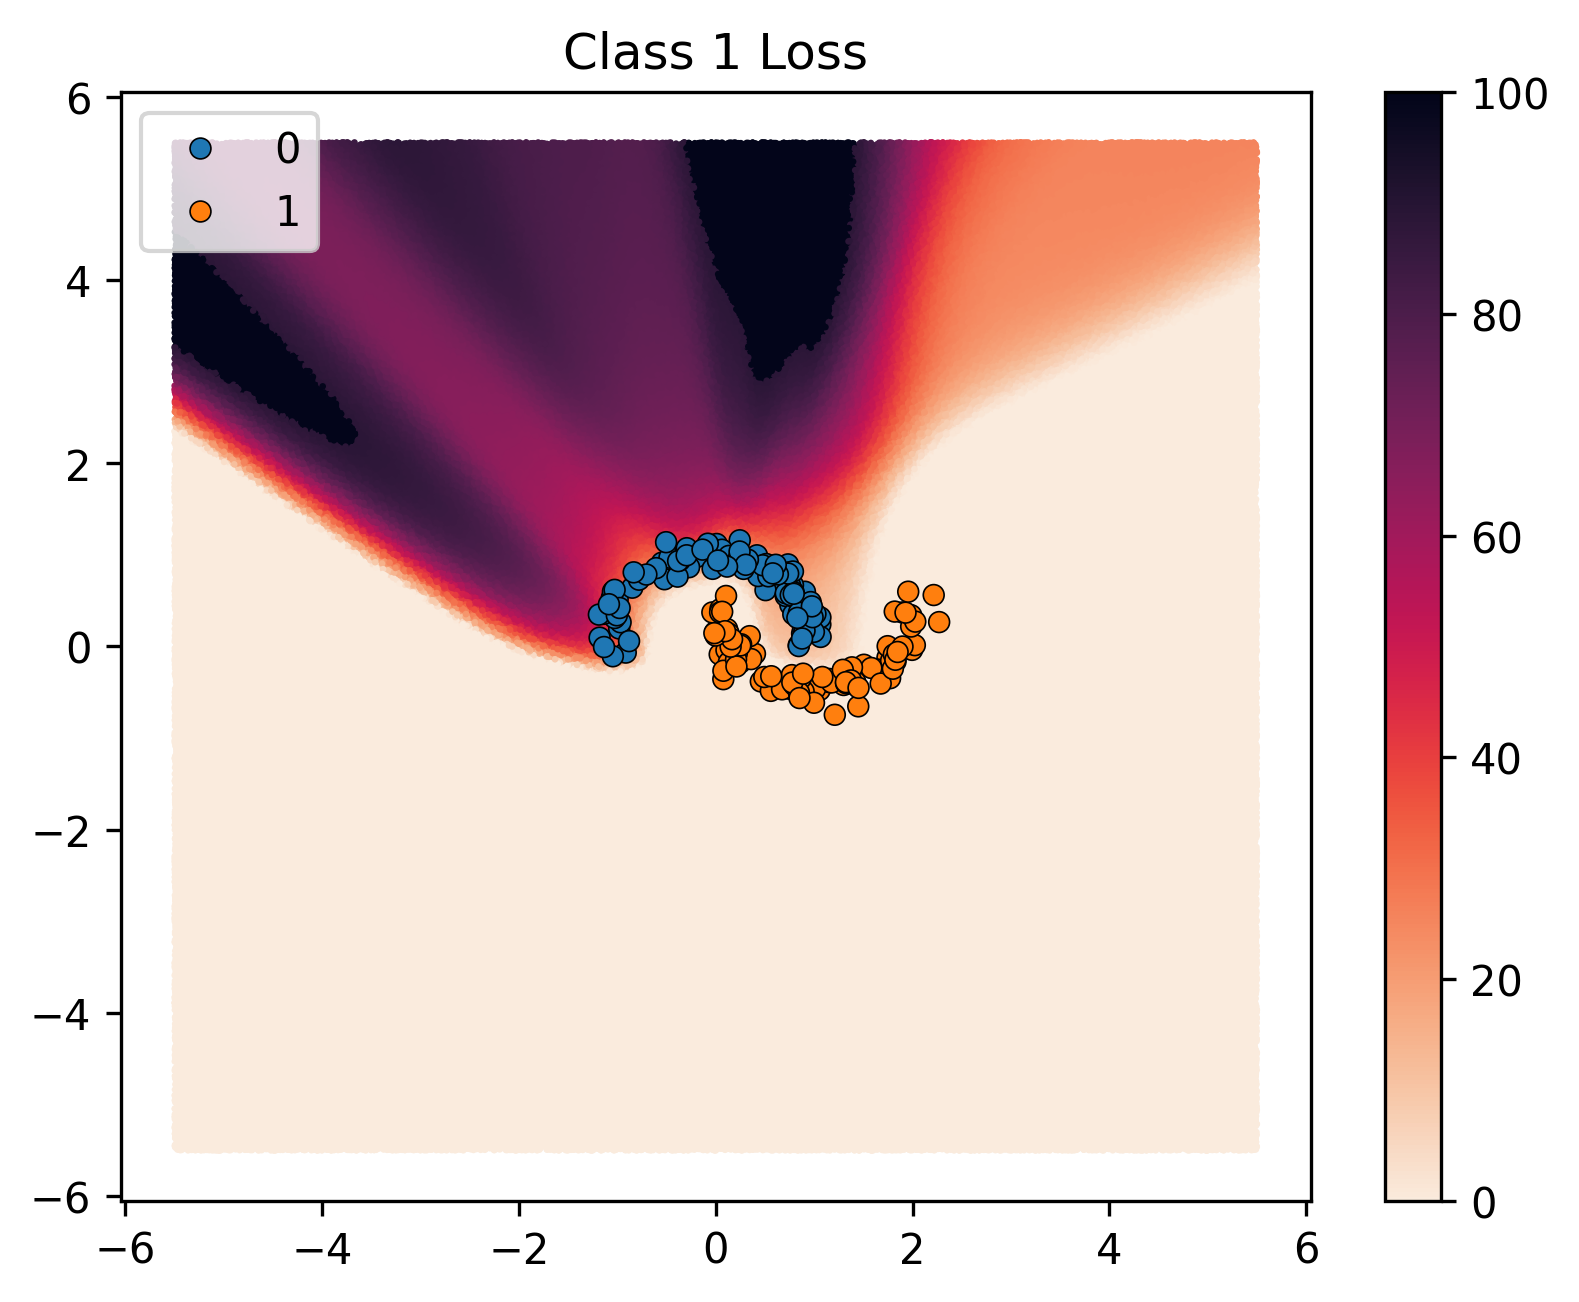

In [112]:
sns.scatterplot(x=viz_x_l.T[0], y=viz_x_l.T[1], hue=viz_loss_1, marker='.', edgecolor=None, legend=None, palette='rocket_r', linewidth=0, s=viz_dotsize)
ax = sns.scatterplot(x=test_x.T[0], y=test_x.T[1], hue=y_hat.T[0].round().int(), edgecolor='black', s=25)
ax.get_legend().set_title(None)
ax.set_ylabel(None)
ax.set_xlabel(None)

norm = plt.Normalize(viz_loss_1.min(), viz_loss_1.max())
sm = plt.cm.ScalarMappable(cmap='rocket_r', norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, ax=ax)

plt.savefig('figures/class_1_loss.png', format='png', transparent=True)

plt.title('Class 1 Loss')